### <b>Dataset Download</b>

* This gender classification dataset has total <b>30,000 images</b> (train: 23,999 / test: 6,001).
* <b>Original dataset</b>: [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        male/
        female/
    <b>test/</b>
        male/
        female/
</pre>

* Script for dataset download:

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ-LQXHjSztIrv5ayecz_nUBdHRni8ko4p_vCS1zypkhOw?download=1 -O CelebA_HQ_face_gender_dataset.zip
!unzip CelebA_HQ_face_gender_dataset.zip -d ./CelebA_HQ_face_gender_dataset
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu") # device object

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = './CelebA_HQ_face_gender_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


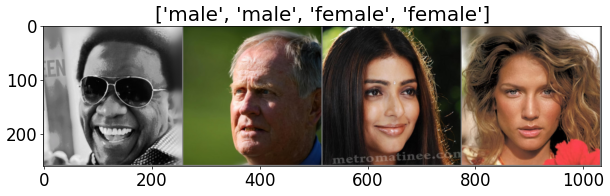

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(inputs, title):
    # torch.Tensor => numpy
    inputs = inputs.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    # display images
    plt.imshow(inputs)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [4]:
model = models.mnasnet1_0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### <b>Training Phase</b>


In [5]:
num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 0.0949 Acc: 96.4373% Time: 107.9070s
[Test #0] Loss: 0.4272 Acc: 86.6189% Time: 137.4780s
[Train #1] Loss: 0.0398 Acc: 98.6374% Time: 245.5902s
[Test #1] Loss: 0.2068 Acc: 94.7009% Time: 273.4807s
[Train #2] Loss: 0.0218 Acc: 99.2541% Time: 384.0563s
[Test #2] Loss: 0.1599 Acc: 95.3841% Time: 411.8705s
[Train #3] Loss: 0.0150 Acc: 99.4666% Time: 520.6211s
[Test #3] Loss: 0.0853 Acc: 97.5837% Time: 548.8713s
[Train #4] Loss: 0.0079 Acc: 99.7667% Time: 658.6955s
[Test #4] Loss: 0.1071 Acc: 97.7837% Time: 686.7030s
[Train #5] Loss: 0.0054 Acc: 99.8417% Time: 794.5853s
[Test #5] Loss: 0.0720 Acc: 97.9004% Time: 822.4260s
[Train #6] Loss: 0.0032 Acc: 99.9167% Time: 924.5767s
[Test #6] Loss: 0.1053 Acc: 98.0337% Time: 951.0699s
[Train #7] Loss: 0.0042 Acc: 99.8542% Time: 1054.8631s
[Test #7] Loss: 0.1883 Acc: 96.9172% Time: 1082.4033s
[Train #8] Loss: 0.0037 Acc: 99.8958% Time: 1187.5438s
[Test #8] Loss: 0.1079 Acc: 98.2336% Time: 1214.8793s
[Train #9] Loss: 0.0026 Acc: 99.9

### <b>Final Test Phase</b>

* Save the trained model file.

In [6]:
save_path = 'face_gender_classification_using_transfer_learning_with_MNASNet_resolution_256_normalize_05.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [7]:
model = models.mnasnet1_0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

* Evaluate the trained model.

[Original Image Examples]


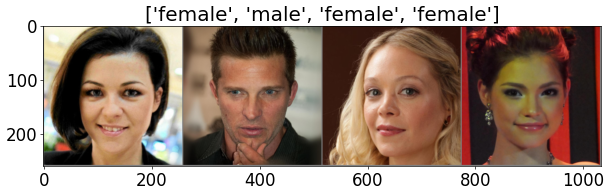

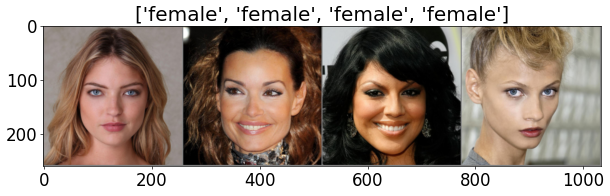

[Prediction Result Examples]


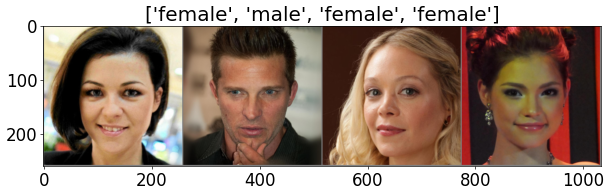

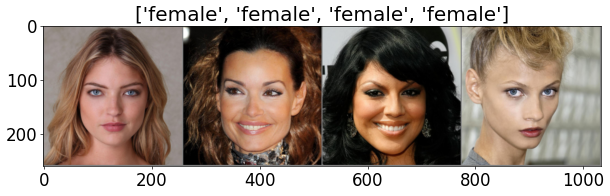

[Test #9] Loss: 0.0786 Acc: 98.3836% Time: 27.2988s


In [8]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))